<a href="https://colab.research.google.com/github/tlsgptj/CJONs/blob/main/cleaning_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 파이썬 버전 확인
!python --version

Python 3.10.6


**0. 필요한 패키지 설치**

In [ ]:
!pip install wordcloud
!pip install transformers

**1. 전처리 및 분석**

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
import urllib.request

In [ ]:
# read_csv() 함수를 사용해 csv파일 읽기
df_Rose = pd.read_csv('/content/drive/MyDrive/와인 리뷰/bert 관련/Château La Tour de lÉvêque Pétale de Rosé (Rose).csv', encoding='cp949')

In [ ]:
df_Rose.shape #데이터 사이즈 확인

(753, 2)

1-1. 결측치 제거

In [ ]:
df_Rose.isnull().sum()

LABEL-2    0
LABEL-3    7
dtype: int64

In [ ]:
df_Rose = df_Rose[~df_Rose['LABEL-3'].isnull()]

1-2. 데이터셋에서 영어만 추출

In [ ]:
!pip install git+https://github.com/Artemis1111/lingua-py.git

  Cloning https://github.com/Artemis1111/lingua-py.git to /tmp/pip-req-build-j7v4tfez
  Running command git clone --filter=blob:none --quiet https://github.com/Artemis1111/lingua-py.git /tmp/pip-req-build-j7v4tfez
  Resolved https://github.com/Artemis1111/lingua-py.git to commit f76c1d3d3fad87e3154d64fa75f03d92ce4463cd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from lingua import Language, LanguageDetectorBuilder
languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.SPANISH, Language.RUSSIAN, Language.CHINESE, Language.JAPANESE, Language.KOREAN, Language.PORTUGUESE, Language.ITALIAN]
detector = LanguageDetectorBuilder.from_languages(*languages).build()
detector.detect_language_of("languages are awesome")

Language.ENGLISH

In [ ]:
def non_eng_remove(df, review_str):
  review_revised = []
  for review in df[review_str]:
    if detector.detect_language_of(review) != Language.ENGLISH:
      review = None
    review_revised.append(review)
  return review_revised

In [ ]:
df_Rose['LABEL-3'] = non_eng_remove(df_Rose, 'LABEL-3')

In [ ]:
df_Rose.isnull().sum()

LABEL-2      0
LABEL-3    423
dtype: int64

In [ ]:
df_Rose = df_Rose[~df_Rose['LABEL-3'].isnull()]

1-3. wordcloud 활용하여 리뷰데이터 시각화

In [ ]:
# 1. 필요한 모듈 불러오기
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib import rc
import re

In [ ]:
df_Rose['LABEL-3']

0      6 grapes mix. ???? delicate but rich bitter-sw...
1                   Refreshing, acidic, strawberry notes
2      I really enjoyed this Ros?, very delicate and ...
3      Medium nose intensity of strawberry violet  ro...
4      Who would have thought? Rose petal on the nose...
                             ...                        
730                                            Favourite
732                                         Awesome Rose
733                                          Nail polish
736                                               Biting
742                                    It's undrinkable.
Name: LABEL-3, Length: 323, dtype: object

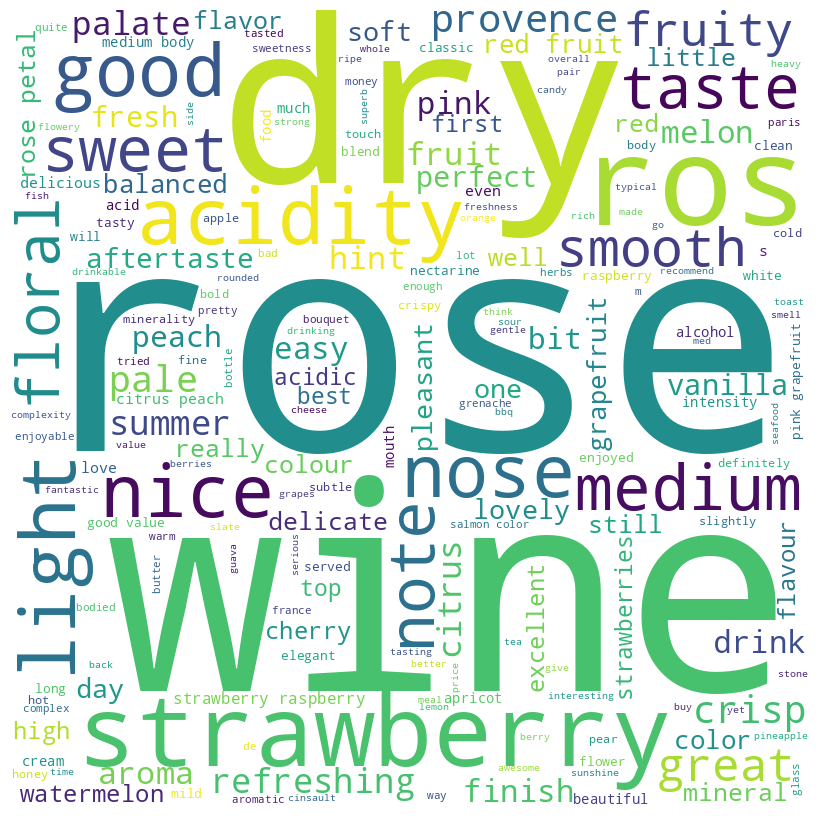

In [ ]:
# 2. Stopwords 및 특수문자 필터링을 위한 준비

comment_words = ''
stopwords = set(STOPWORDS)

tokenized_text = []

# 3. 문장 데이터를 단어화하기
for val in df_Rose["LABEL-3"]:

  # 문장을 string으로 만들기
  val = str(val)

  # 문장을 소문자로 바꾸기
  val = val.lower()

  #문장 속 문장부호 지우기
  val = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@\[\]^_\`{|}~\\\\]','', val)

  # 문장을 쪼개기
  tokens = val.split()

  tokenized_text.append(tokens)
  comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# 필터링할 추가적인 stopwords들 정의

stopwords_Rose = ["rose", 'wine', 'good', 'nice', 'nose', 'really', 'first', 'great', 'little',
                  'high', 'easy', 'top', 'color', 'long', 'tasty', 'excellent', 'ros', 'very', 'notes',
                  'taste', 'colour', 'still', 'one', 'well', 'roses', 'perfect', 'drink', 'aftertaste',
                  'value'
]
stopwords_name = ['provence'
]

In [ ]:
# 토큰화된 문장확인
tokenized_text[0]

['6',
 'grapes',
 'mix',
 'delicate',
 'but',
 'rich',
 'bittersweet',
 'strawberry',
 'l',
 'acidity']

In [ ]:
def filter_stopwords(tokenized_text, stopwords_2, stopword_3):
  tokenized_filtered = []

  for i in tokenized_text:
    for word in i:
      if word not in stopwords and word not in stopwords_2 and word not in stopword_3:
        tokenized_filtered.append(word)

  return tokenized_filtered

In [ ]:
len(tokenized_text)

323

In [ ]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_Rose, stopwords_name)

In [ ]:
# 필터링 되었는지 확인
tokenized_filtered[0:10]

['6',
 'grapes',
 'mix',
 'delicate',
 'rich',
 'bittersweet',
 'strawberry',
 'l',
 'acidity',
 'refreshing']

In [ ]:
len(tokenized_filtered)

2264

In [ ]:
import operator

def word_count(tokenized_data):
  word_counter = {}

  for i in tokenized_data:
    if i in word_counter.keys():
      word_counter[i] += 1
    else:
      word_counter[i] = 1

  # 많이 나온 순서대로 정렬

  sorted_dict = dict( sorted(word_counter.items(),
                           key=operator.itemgetter(1), reverse=True))

  return sorted_dict

In [ ]:
tokenized_dict = word_count(tokenized_filtered)

In [ ]:
# 가장 상위 20개의 단어 보기
def top_20(tokenized_dict):
  top_20_words = list(tokenized_dict.items())[:20]
  return top_20_words

top_20(tokenized_dict)

[('dry', 60),
 ('strawberry', 57),
 ('acidity', 45),
 ('light', 43),
 ('medium', 36),
 ('sweet', 28),
 ('citrus', 27),
 ('floral', 25),
 ('smooth', 25),
 ('peach', 24),
 ('fruity', 24),
 ('pink', 23),
 ('red', 22),
 ('fruit', 22),
 ('crisp', 21),
 ('refreshing', 20),
 ('summer', 20),
 ('pale', 20),
 ('palate', 19),
 ('grapefruit', 18)]

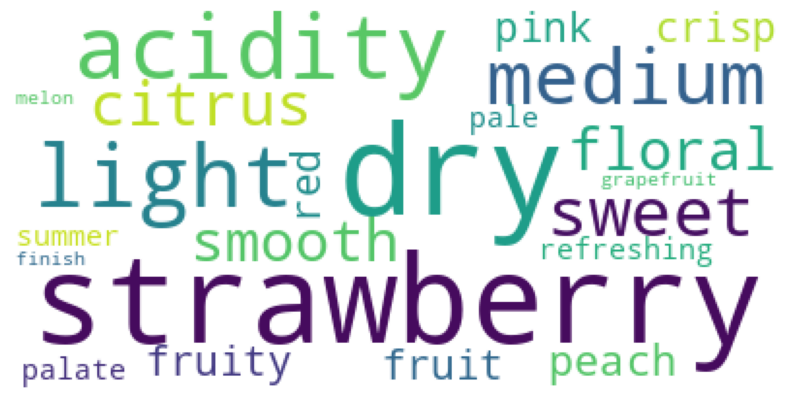

In [ ]:
wc = WordCloud(background_color="white", min_font_size=10)
cloud = wc.generate_from_frequencies(tokenized_dict)


plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

2. 모델링
2.1  모델링을 위한 준비
BERT 준비

In [ ]:
# Bert 사용에 필요한 모듈 불러오기
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences

import pandas as pd
import numpy as np
import random
import time
import datetime

In [ ]:
# BERT에 맞는 Tag 달아주기
bert_text = []

for i in ['']:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  bert_text.append(bert)

bert_text[:5]

[['[CLS]  [SEP]']]

In [ ]:
!pip install sentencepiece transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# 가상의 데이터셋 (라벨링된 데이터셋이 필요합니다)
data = [
    ("This wine is delicious!", 1),
    ("I didn't like the taste of this wine.", 0),

]

class WineSentimentDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        label = torch.tensor(label)
        return inputs, label

# 모델 정의
class WineSentimentClassifier(nn.Module):
    def __init__(self, num_labels):
        super(WineSentimentClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    def forward(self, inputs):
        outputs = self.bert(**inputs)
        return outputs.logits

# 데이터셋과 모델 준비
wine_sentiment_dataset = WineSentimentDataset(data)
train_loader = DataLoader(wine_sentiment_dataset, batch_size=8, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WineSentimentClassifier(num_labels=2).to(device)

# Loss 함수와 Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# 학습
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, labels in train_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 2), labels)
        loss.backward()
        optimizer.step()

# 감정분석 함수 정의
def wine_sentiment_analysis(text):
    model.eval()
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits).item()
    return "Positive" if predicted_label == 1 else "Negative"

# 감정분석 예시
text1 = "This wine is amazing!"
text2 = "The taste of this wine is terrible."
print(wine_sentiment_analysis(text1))  # Output: "Positive"
print(wine_sentiment_analysis(text2))  # Output: "Negative"


In [ ]:
import pandas as pd
df = pd.read_excel("/content/Tenuta Romana Soliditas.xlsx")

In [ ]:
df

,Score,Review,Rating
0,4.0,"Peat and cherry vanilla on the nose. Light, si...",Warren Lapine (2140 ratings)
1,4.0,"For the price, quite good. Expressive and expl...",Christiaan Ketelaar (1149 ratings)
2,4.0,"Always an enjoyable pour. Warm notes of cocoa,...",Brett Barthlow (984 ratings)
3,4.0,"3.75. Medium body, garnet color, cherry on t...",Michael Polyak (492 ratings)
4,4.0,Wonderful value for money. The best choice for...,Orfeo (602 ratings)
...,...,...,...
485,4.0,Semi dry red wine.,Maksym Keplin (246 ratings)
486,4.0,"Lovely, smooth and fruity. Really yummy to dri...",Xerxes Sethna (201 ratings)
487,4.0,"Smoky, good with food not a wine to potter abo...",J R B (368 ratings)
488,3.8,"Plum, grape, pomegranate",James Martin (287 ratings)


In [ ]:
import pandas as pd

# 엑셀 파일 읽어오기
file_path = '/content/Tenuta Romana Soliditas.xlsx'
df = pd.read_excel(file_path)

# 괄호 안에 있는 부분 나누기
df['Ratings'] = df['Rating'].str.extract(r'\((\d+)\sratings\)')
df['Rating'] = df['Rating'].str.replace(r'\s\(\d+\sratings\)', '')

# 결과 출력
print(df)

     Score                                             Review  \
0      4.0  Peat and cherry vanilla on the nose. Light, si...   
1      4.0  For the price, quite good. Expressive and expl...   
2      4.0  Always an enjoyable pour. Warm notes of cocoa,...   
3      4.0  3.75.  Medium body, garnet color,  cherry on t...   
4      4.0  Wonderful value for money. The best choice for...   
..     ...                                                ...   
485    4.0                                 Semi dry red wine.   
486    4.0  Lovely, smooth and fruity. Really yummy to dri...   
487    4.0  Smoky, good with food not a wine to potter abo...   
488    3.8                           Plum, grape, pomegranate   
489    4.0      Easy to drink. Dry but smooth. Very balanced.   

                  Rating Ratings  
0          Warren Lapine    2140  
1    Christiaan Ketelaar    1149  
2         Brett Barthlow     984  
3         Michael Polyak     492  
4                  Orfeo     602  
..       

<ipython-input-6-b1442acca639>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Rating'] = df['Rating'].str.replace(r'\s\(\d+\sratings\)', '')


In [ ]:
df

,Score,Review,Rating,Ratings
0,4.0,"Peat and cherry vanilla on the nose. Light, si...",Warren Lapine,2140
1,4.0,"For the price, quite good. Expressive and expl...",Christiaan Ketelaar,1149
2,4.0,"Always an enjoyable pour. Warm notes of cocoa,...",Brett Barthlow,984
3,4.0,"3.75. Medium body, garnet color, cherry on t...",Michael Polyak,492
4,4.0,Wonderful value for money. The best choice for...,Orfeo,602
...,...,...,...,...
485,4.0,Semi dry red wine.,Maksym Keplin,246
486,4.0,"Lovely, smooth and fruity. Really yummy to dri...",Xerxes Sethna,201
487,4.0,"Smoky, good with food not a wine to potter abo...",J R B,368
488,3.8,"Plum, grape, pomegranate",James Martin,287


In [ ]:
df.to_csv("red.csv", index=False)

In [ ]:
from google.colab import files

# 파일 다운로드 링크 생성
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Set up the word cloud parameters
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='viridis',
                      min_font_size=10,
                      max_words=200,
                      collocations=False)

In [ ]:
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
df["Review"] = df["Review"].apply(lambda x: word_tokenize(x))

AttributeError: ignored

In [ ]:
!pip install numpy

In [ ]:
!pip install nltk

In [ ]:
pip install numpy==1.20.3

  Using cached numpy-1.20.3.zip (7.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects


In [ ]:
pip install path/to/numpy-1.20.3-cpXX-cpXX-win_amd64.whl

ERROR: numpy-1.20.3-cpXX-cpXX-win_amd64.whl is not a supported wheel on this platform.


In [ ]:
pip install nltk==X.X.X


ERROR: Could not find a version that satisfies the requirement nltk==X.X.X (from versions: 2.0b8.macosx-10.5-i386, 2.0.1rc1.macosx-10.6-x86_64, 2.0.1rc2-git, 2.0b4, 2.0b5, 2.0b6, 2.0b7, 2.0b8, 2.0b9, 2.0.1rc1, 2.0.1rc3, 2.0.1rc4, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 3.0.0b1, 3.0.0b2, 3.0.0, 3.0.1, 3.0.2, 3.0.3, 3.0.4, 3.0.5, 3.1, 3.2, 3.2.1, 3.2.2, 3.2.3, 3.2.4, 3.2.5, 3.3.0, 3.4, 3.4.1, 3.4.2, 3.4.3, 3.4.4, 3.4.5, 3.5b1, 3.5, 3.6, 3.6.1, 3.6.2, 3.6.3, 3.6.4, 3.6.5, 3.6.6, 3.6.7, 3.7, 3.8, 3.8.1)
ERROR: No matching distribution found for nltk==X.X.X
